# Anomaly Detection: Isolation Forest

Isolation Forest: Liu, Fei Tony, Kai Ming Ting, and Zhi-Hua Zhou. "Isolation forest." 2008 eighth ieee international conference on data mining. IEEE, 2008.

## Isolation Forest의 기본 가정은 다음과 같다

1. 정상 데이터는 상대적으로 고립(split)시키기 어렵다
2. 이상 데이터는 상대적으로 고립(split)시키키 쉽다

그림의 좌측이 1번 경우인데, 정상 데이터는 주변 데이터와 유사하기 때문에 이를 분리하기 위해선 많은 시도(분할, split)가 필요하다

반면, 이상치 데이터는 주변 데이터와 상이하기 때문에 이를 분리하기 위해선 상대적으로 적은 수의 시도(분할,split)가 필요하다

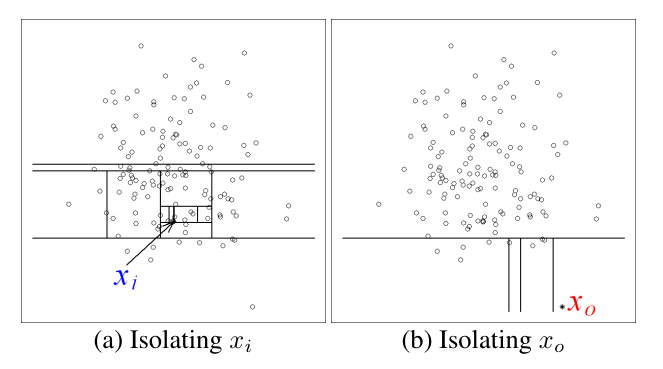

In [2]:
from IPython.display import Image
Image('./images/isolating.PNG')

실제로 많은 수의 반복 실험을 진행해도, 정상 데이터와 이상치 데이터를 완벽하게 분할(split)하기 위한 시도는 평균적으로 차이가 존재한다 

(위: 이상치, 아래: 정상)

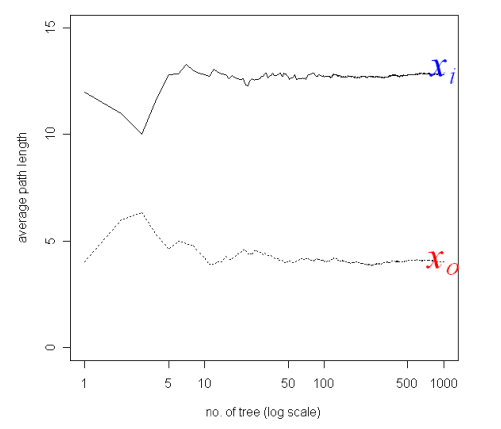

In [3]:
Image('./images/average.PNG')

만약, 이러한 가정이 성립한다면 '데이터를 완벽하기 분할하기 위한 평균적인 시도(split)'는 이상치를 정의할 수 있는 하나의 score가 될 수 있을 것이다.

이런 motivation에서 탄생한 것이 isolation forest 알고리즘이고, 이 알고리즘은 매우 직관적이고 데이터의 사전 분포를 고려하지 않는다는 특징이 있다.

## Import Libraries and Packages

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
from pprint import pprint
import seaborn as sns
import pdb
sns.set_style(style="whitegrid")
from matplotlib import rcParams
import warnings
warnings.filterwarnings(action='ignore')


%matplotlib inline
plt.style.use('fivethirtyeight')
rcParams['axes.labelsize'] = 14
rcParams['xtick.labelsize'] = 12
rcParams['ytick.labelsize'] = 12
rcParams['text.color'] = 'Black'
rcParams['figure.figsize'] = 16,8

## Sample Data 생성

### 1. Normal Data 생성

In [5]:
mean = [0, 0] # 평균이 1 
covariance = [[1, 0], [0, 1]]  # diagonal covariance
num = 2000
x, y = np.random.multivariate_normal(mean, covariance, num).T # 다변량 정규분포 데이터 생성

### 2. Outlier Data 생성

In [6]:
def create_outlier(mean, x, y, numbers):
    '''
    평균이 mean, 표준편차가 1 인 이상치 데이터 n개 생성
    '''
    for i in range(numbers):
        
        x[i] = np.random.normal(mean, 1, 1) # mu, sigma, num
        y[i] = np.random.normal(mean, 1, 1) # mu, sigma, num



### 3. Dateset 생성 및 분포 시각화

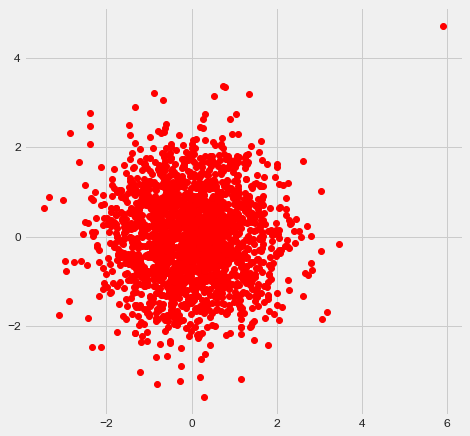

In [7]:
create_outlier(5,x,y,1) # 평균이 5인, 1개의 이상치 데이터 생성

Data= np.array([x,y]).T
Data = pd.DataFrame(Data,columns=['Feature1','Feature2'])

plt.figure(figsize=(7,7))
plt.plot(x,y,'ro')
plt.show()

실제로 평균이 4인 이상치 데이터들이 우측 상단에 잘 형성된 것을 확인할 수 있다.

## Functions for Isolation Tree

### 1개의 Isolation Tree를 만들기 위한 함수

In [8]:
def select_attribute(data):
    '''
    Isolation을 진행하기 위해 랜덤으로 변수 선택
    '''
    return random.choice(data.columns)

def split_point(data, columns):
    '''
    랜덤으로 선택된 변수 중에서 split point 선정
    '''
    min = np.min(data[columns])
    max = np.max(data[columns])
    
    split = (max - min)*np.random.random() + min
    
    return split

def split_data(data, attribute, splitpoint):
    '''
    split point 기준으로 데이터 분할
    '''
    data_up = data[data[attribute] > splitpoint] # 큰 값
    data_down = data[data[attribute] <= splitpoint]  # 작은 값
    
    return data_up, data_down

def data_classification(data):
    '''
    최종적으로 분할이되는 value 추출
    '''
    colummn_values = data.values[:,-1] # dataframe에서 value만 추출
    unique_values, value_counts = np.unique(colummn_values, return_counts=True)
    value_index = value_counts.argmax() # 가장 많이 나온 value의 index 추출 ()
    classification = unique_values[value_index] # index에 맞는 value값 return
    
    return classification

## Isolation Tree

In [9]:
def isolation_tree(data, count=0, max_depth=50):
    '''
    Isolation Forest를 만들기 위한 1개의 Isolation Tree 생성
    max_depth: 최대로 분할하는 횟수(Hyperparameter)
    '''
    # 최대 분할 횟수에 도달하거나 Data가 1개만 존재하면
    if (count == max_depth) or data.shape[0] <=1: 
        classification = data_classification(data)
        
        return classification
    
    else:
        # count
        count += 1
        
        # 변수 선택
        attribute = select_attribute(data)
        
        # 변수 내 분할점 선택
        split = split_point(data, attribute)
        
        # 변수 내 분할점 기준 분할
        data_up, data_down = split_data(data, attribute, split)
        
        # 분할 시도
        split_try = "{} =< {}".format(attribute, split)

        # sub_tree dictionary에 저장
        sub_tree = {split_try: []}
        
        # 재귀함수
        answer_up = isolation_tree(data_up, count, max_depth=max_depth) 
        answer_down = isolation_tree(data_down, count, max_depth=max_depth)
        
        if answer_down == answer_up: #  분할되는 값이 같아지면 stop! 
            sub_tree = answer_down
        
        else: # 분할될때 까지 
            sub_tree[split_try].append(answer_down)
            sub_tree[split_try].append(answer_up)
        
        
        return sub_tree

In [10]:
# Max Depth 1로 설정해 놓고 확인 

tree = isolation_tree(Data, max_depth=1)
print(tree)

{'Feature2 =< -2.8178717531257242': [-3.5789555145122978, -2.731932554715979]}


분할 시도를 1번만 한다고 가정했을때, 

1. 랜덤으로 선택된 변수는: Feature 1
2. Featrue1 중 1.1714041316097887 보다 작은 값은 [-3.610538498642096, -2.8698144525447495] 이다

## Isolation Forest Sample Size

Isolation Forest를 처음 소개한 논문에는 sample 사이즈와 성능에 대한 성능 비교가 나온다.

왼쪽 original sample은 4096개, 오른쪽 sub-smaple은 128개의 샘플링된 데이터이다.

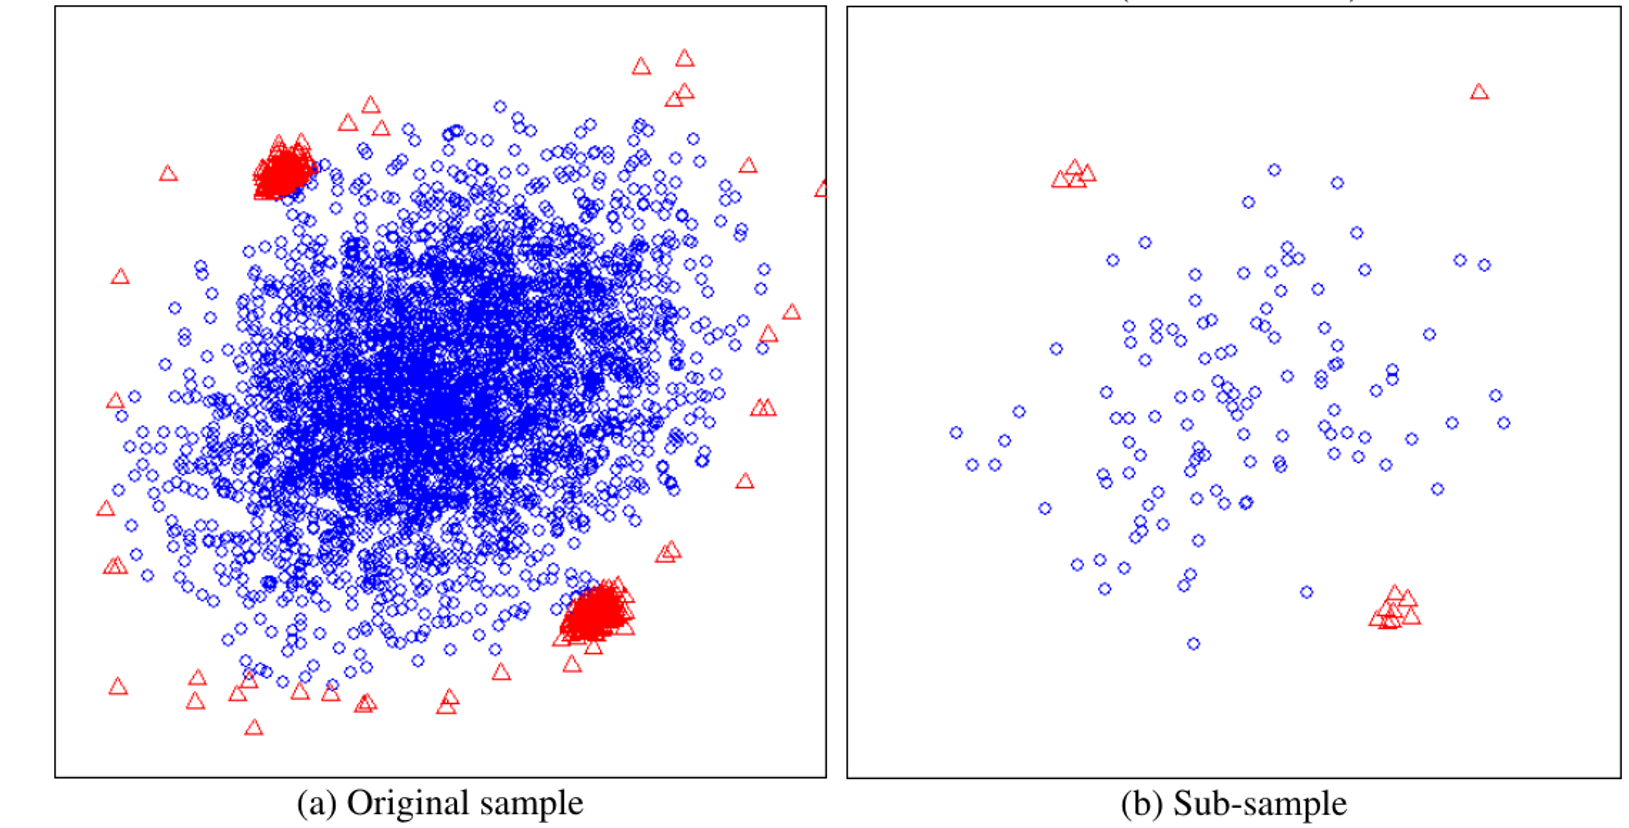

In [11]:
Image('./images/subsample.png')

이때, original sample을 사용한 iforest의 성능은 AUC 기준 0.67 이고 sub-sample을 사용한 iforest의 성능은 AUC 기준 0.91이다.

따라서, 모든 데이터를 사용하는 것 보다는 일부 데이터를 추출해서 사용하는 것이 효과적일 수 있다.

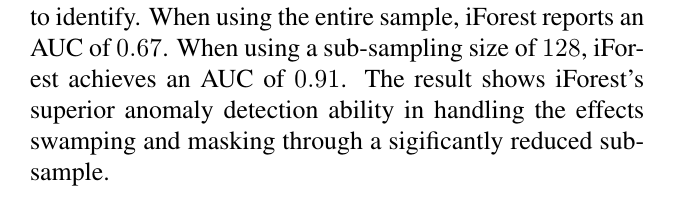

In [12]:
Image('./images/subsample_auc.png')

## Isolation Forest

In [13]:
def isolation_forest(data, num_trees=5, max_depth=5, subspace=1000):
    '''
    Isolation Tree를 합쳐서 Isolation Forest 생성 
    num_tress: hyperparameter로 isolation forest를 몇 개 만들것인지 정의한다
    subspace: hyperparameter로 데이터 중에 일부만 추출하여 사용한다
    
    '''
    forest = []

    for _ in range(num_trees):
        # Sample the subspace
        if subspace<=1:
            data = data.sample(frac=subspace)
        else:
            data = data.sample(subspace)
        

        # Fit tree
        tree = isolation_tree(data, max_depth=max_depth)
        
        # Save tree to forest
        forest.append(tree)
    
    return forest

In [14]:
# 5개의 isolation tree로 만들어진 isolation forest 확인 (max dept =1)
isolation_forest(Data, num_trees=5, max_depth=1)

[{'Feature2 =< 1.606223283208759': [-3.5789555145122978, 1.607750919791716]},
 {'Feature1 =< 0.24239005738841612': [-3.145075256925853,
   -3.5789555145122978]},
 {'Feature2 =< -0.5495442437278113': [-3.5789555145122978,
   -0.5485381492352756]},
 {'Feature1 =< 0.8572927593517461': [-3.5789555145122978, -3.17905823242397]},
 {'Feature1 =< -2.7678869431425412': [-1.4382285971798252,
   -3.5789555145122978]}]

## Path Length

데이터가 완전히 isolation 분할될때까지의 split한 횟수를 의미한다.

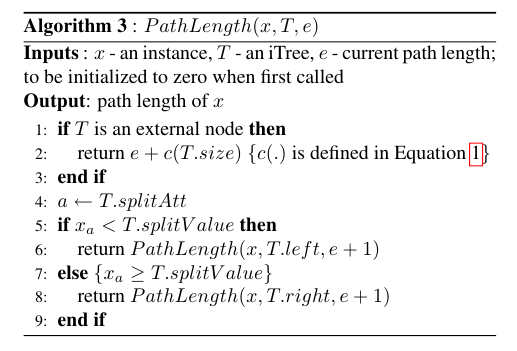

In [15]:
Image('./images/path_length.PNG')

In [16]:
def pathLength(data, iTree, path=0, trace=False):
    
    path = path + 1
    question = list(iTree.keys())[0] # 첫 번째 split 여부 가져오기 
    feature_name, _, value = question.split() 
    # ex) feature_name, _, value = 'Feature2 =< -1.0255974427929273'
    
    # ask question
    if data[feature_name].values <= float(value):
        answer = iTree[question][0]
    else:
        answer = iTree[question][1]
        
        
    # Base Node 도착
    if not isinstance(answer, dict):
        return path
    
    # 재귀함수 시작
    else: # Base Node가 아니라면
        residual_tree = answer 
        return pathLength(data, residual_tree, path=path)

In [17]:
# Data에서 Random으로 샘플링한 데이터의 path length 실험

tree = isolation_tree(Data,max_depth=3)
ins = Data.sample(1)
paht_length = pathLength(ins,tree)

print(f"{ins}")
print(f'랜덤으로 추출된 데이터의 path length는 {paht_length}이다')

     Feature1  Feature2
697 -0.591879 -0.643788
랜덤으로 추출된 데이터의 path length는 3이다


## Plot

In [18]:
def makeline(data, example, iTree, path=0,line_width=1):
    
    path=path+1
    question = list(iTree.keys())[0]
    feature_name, _, value = question.split()
    print(question)
    
    if example[feature_name].values <= float(value):
        answer = iTree[question][0]
        data = data[data[feature_name] <= float(value)]
    else:
        answer = iTree[question][1]
        data = data[data[feature_name] > float(value)]
        

    if feature_name == 'Feature1':
        plt.hlines(float(value), 
                   xmin=data.Feature1.min(),
                   xmax=data.Feature1.max(),
                   linewidths=line_width)
    else:
        plt.vlines(float(value),
                   ymin=data.Feature2.min(),
                   ymax=data.Feature2.max(),
                   linewidths=line_width)
             
        
    # Base Node
    if not isinstance(answer, dict):
        return path
    
    # 재귀함수
    else:
        if feature_name == 'Feature1':
            plt.hlines(float(value),xmin=data.Feature1.min(),xmax=data.Feature1.max(),linewidths=line_width)
        else:
            plt.vlines(float(value),ymin=data.Feature2.min(),ymax=data.Feature2.max(),linewidths=line_width)
        residual_tree = answer
        return makeline(data,example, residual_tree,path=path,line_width=line_width)

def make_plot(data,example, iTree):
    plt.figure()
    plt.plot(data['Feature1'],data['Feature2'],'bo',alpha=0.2)
    plt.xlabel('Feature1')
    plt.ylabel('Feature2')
    plt.ylim(-3,3)
    plt.xlim(-3,3)
      
    # Splitline 생성
    makeline(data,example,tree)
    

    # Plot the point we are looking for
    plt.scatter(x=example.Feature1,
                y=ins.Feature2,
                c='r',marker='o')
    
    plt.show()

     Feature1  Feature2
451  0.218685  0.983789
Feature1 =< -1.2906462052642964
Feature2 =< 0.9844193405703212
Feature1 =< -1.1013386218554326
Feature2 =< -0.12051006932261332
Feature2 =< 0.5666127188251731
Feature1 =< 0.39149507839512443
Feature1 =< -0.06147720194668893


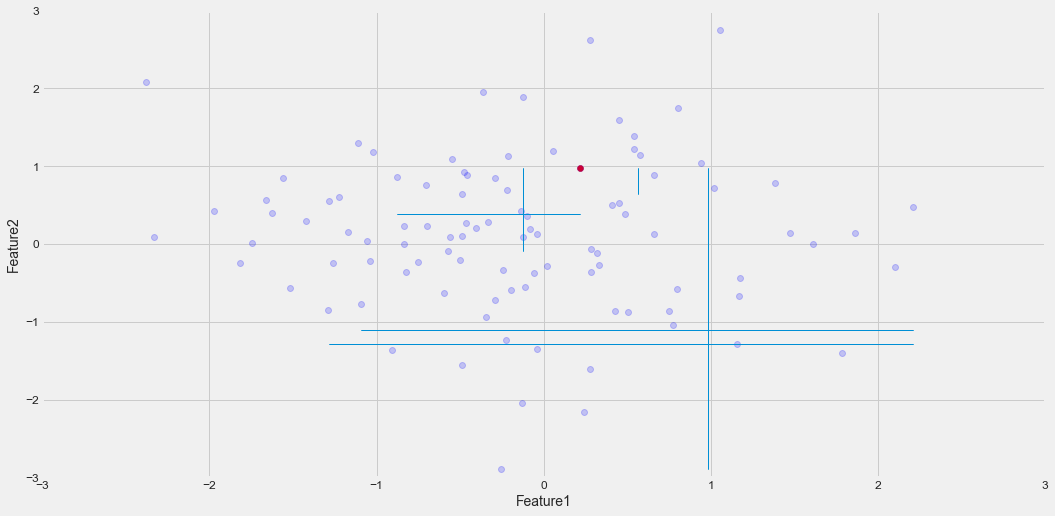

In [19]:
data_plot = Data.sample(100)
ins = data_plot.sample(1)

print(f"{ins}")

tree = isolation_tree(data_plot,max_depth=100)

make_plot(data_plot, ins, tree)

## Evaluate

Isolation Forest 생성

In [20]:
iForest = isolation_forest(Data, num_trees=50, max_depth=100, subspace=256)

위에서 언급한 Path length를 계산

In [21]:
def evaluate_instance(instance,forest):
    paths = []
    for tree in forest:
        paths.append(pathLength(instance,tree))
    return paths 

Path Length는 오일러 상수를 사용해서 다음과 같은 식으로 정규화될 수 있다!

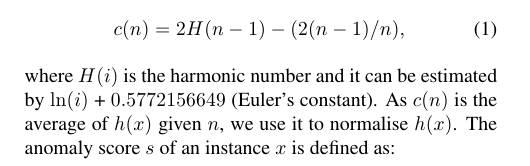

In [22]:
Image('./images/c_factor.PNG')

In [23]:
def c_factor(n) :
    return 2.0*(np.log(n-1)+0.5772156649) - (2*(n-1)/(n))


이상치 점수는 아래 식으로 정의된다.

1. 특정 객체의 평균 path length가 큰 경우 = split 하기 어려운 경우 = 정상에 가까운 경우 anomaly score는 0 으로 근사하고

2. 특정 객체의 평균 path length가 짧은 경우 = split 하기 쉬운 경우 = 이상치에 가까운 경우 anomaly score는 1로 근사한다

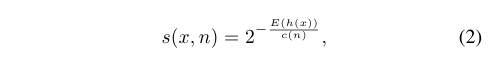

In [24]:
Image('./images/anomaly_score.PNG')

In [25]:
def anomaly_score(data_point,forest,n):
    '''
    '''
    # Mean depth for an instance
    E = np.mean(evaluate_instance(data_point, forest))
    
    c = c_factor(n)
    
    return 2**-(E/c)

## Evaluate whole dataset

In [26]:
an= []
for i in range(Data.shape[0]):
    an.append(anomaly_score(Data.iloc[[i]],iForest,256))

In [27]:
def instance_depth_plot(instance, outlier, forest):
    
    bars1 = evaluate_instance(outlier,forest)

    bars2 = evaluate_instance(instance,forest)


    barWidth = 0.3

    # The x position of bars
    r1 = np.arange(len(bars1))
    r2 = [x + barWidth for x in r1]
    
    # Create cyan bars
    plt.bar(r2, bars2, width = barWidth, capsize=7, label='Normal Sample')

    # Create blue bars
    plt.bar(r1, bars1, width = barWidth,  capsize=7, label='Outlier')



    plt.ylabel('Tree Depth')
    plt.xlabel('Trees')
    plt.legend()
    plt.show()

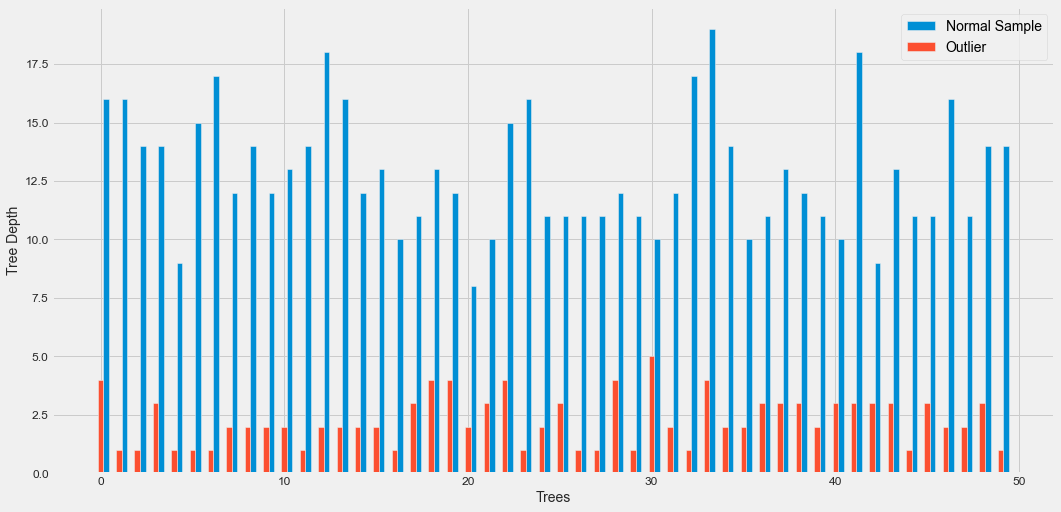

In [28]:
instance_depth_plot(Data.sample(1), # 실험
                    Data.head(1), # outlier
                    iForest)

전반적으로 거의 모든 경우에서 이상치를 split 하기 위해 분류하는 횟수가 높았음을 확인할 수 있다.

In [29]:
outlier  = evaluate_instance(Data.head(1),iForest)
normal  = evaluate_instance(Data.sample(1),iForest)

print(f"평균적으로 이상치 데이터를 split한 횟수는 {np.mean(outlier)}번이고 정상 데이터를 split한 횟수는 {np.mean(normal)}이다")

평균적으로 이상치 데이터를 split한 횟수는 2.28번이고 정상 데이터를 split한 횟수는 12.54이다


In [30]:
iForest = isolation_forest(Data, num_trees=20, max_depth =100, subspace=1000)

print('outlier의 이상치 점수는:',anomaly_score(Data.head(0), iForest, 1000))
print('normal의 이상치 점수는:',anomaly_score(Data.sample(1),iForest, 1000))

outlier의 이상치 점수는: 0.8749343142574411
normal의 이상치 점수는: 0.5351125097721703


실제로 outlier의 이상치 점수가 1에 가까웠고, 정상 데이터의 이상치 점수가 0에 가까웠음을 확인할 수 있다.

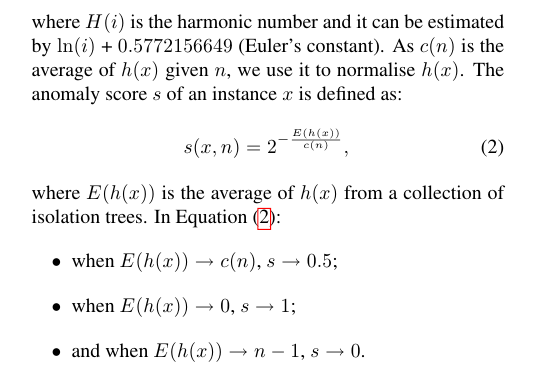

In [31]:
Image('./images/anomaly_score2.PNG')